# Mesh generation/refinement for real glacier geometry

We use several datasets to create a mesh of Luggye glacier, which is refined near the terminus to eventually accommodate calving physics. This is based on an already-created .exp file describing a polygon for Luggye's outline (obtained as the intersection of the RGI outline with our own DEM). We have also manually delineated Luggye's terminus position from the date most closely aligning with the DEM (DEM from 18 October, 2025, terminus from 20 October). After meshing the outline, we refine based on distance from the terminus. 

In [1]:
######################
### issm functions ###
######################

from model import model
from bamg import bamg

######################
### python modules ###
######################

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely import LineString
from shapely.geometry import Point

data_dir = '/home/mielebzu/data/'
dem_dir = data_dir + 'dems'
dem_file = dem_dir + '/luggye_2025_ds.tif'
exp_dir = data_dir + 'exp_files'
os.chdir(exp_dir)

could not import shapefile, PyShp has not been installed, no shapefile reading capabilities enabled


## Initialize the model

In [2]:
min_cellsize, max_cellsize = 50, 50 #in metres
refined = 20 #size of the refined mesh cells

md = model()
md = bamg(md, 'domain', 'DomainOutline_20260126_162319.exp', 'hmax', max_cellsize, 'hmin', min_cellsize)

At least one contour was not correctly oriented and has been re-oriented


## Load the terminus curve

In [3]:
terminus = LineString([ #copy/pasted from GEEDiT
    (90.31877330330583, 28.09807611129586),
    (90.31919172791216, 28.098104504384743),
    (90.31958869484636, 28.0979909319842),
    (90.31985691574785, 28.09783950192981),
    (90.32003930596086, 28.097602892042097),
    (90.32007149246904, 28.097356817205473),
    (90.3201358654854, 28.097176992929565),
    (90.32029679802629, 28.096940381581167),
    (90.32055429009172, 28.09669430522543),
    (90.32076886681291, 28.096438763797273),
    (90.32100490120622, 28.096154828163456),
    (90.32110146073076, 28.095889820894154),
    (90.32110146073076, 28.095539631713223),
    (90.32101563004228, 28.095113724412702)
])

terminus_gdf = gpd.GeoSeries([terminus], crs = 'EPSG:4326').to_crs(epsg = 32645) #reproject 
terminus_utm = terminus_gdf.iloc[0]

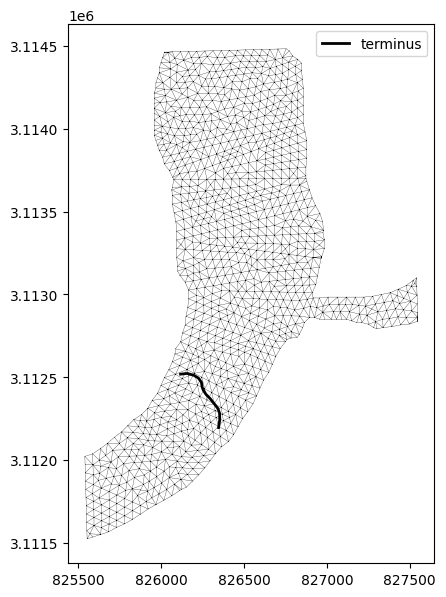

In [4]:
mx, my = md.mesh.x, md.mesh.y
elts = md.mesh.elements - 1
tx, ty = np.array(terminus_utm.coords).T

plt.figure(figsize = (7, 7))
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.2)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Create criterion for refinement

We will write a scalar field which has its largest values close to the terminus LineString, and approaches zero far away from it. 

In [5]:
d = np.array([terminus_utm.distance(Point(xi, yi)) for xi, yi in zip(md.mesh.x, md.mesh.y)]) #distances from terminus, for each mesh node
L = 50 #half-width of the zone of increased refinement (metres from the terminus)
d = np.exp(-(d/L)**2) #cornert "d" into an exponential which peaks close to the terminus
md = bamg(md, 'field', d, 'err', 1e-3, 'hmin', refined, 'hmax', max_cellsize) #good value for "err" obtained by brute force

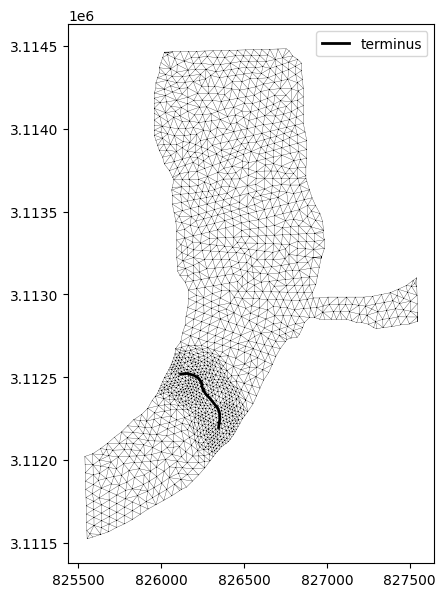

In [6]:
mx, my = md.mesh.x, md.mesh.y #redefine for new mesh
elts = md.mesh.elements - 1

plt.figure(figsize = (7, 7))
plt.triplot(mx, my, elts, color = 'k', linewidth = 0.2)
plt.plot(tx, ty, 'k-', linewidth = 2, label = 'terminus')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Bonus: interpolate DEM data

Open DEM data and project onto mesh points. 

In [9]:
import rasterio

with rasterio.open(dem_file) as src:
    z = src.read(1).astype(float)
    t = src.transform

col, row = (~t*(mx, my))
col = col.astype(int)
row = row.astype(int)

dem_on_mesh = z[row, col]

waterline = 4500
dem_on_mesh[np.where(np.isnan(dem_on_mesh))] = waterline #for now, set nans to waterline level
dem_on_mesh[dem_on_mesh < waterline] = waterline #and anything below waterline level as well
md.geometry.surface = dem_on_mesh #this can be the surface 

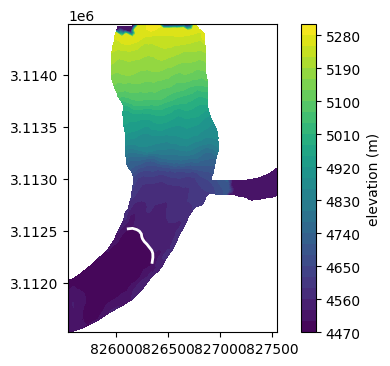

In [10]:
plt.figure(figsize = (6, 4))
plt.tricontourf(mx, my, elts, md.geometry.surface, levels = 30)
plt.plot(tx, ty, 'w-', linewidth = 2, label = 'terminus')

plt.colorbar(label = 'elevation (m)')
plt.gca().set_aspect('equal')
plt.show()